## Deep Learning - Unit 14 Homework 
#### Gregory Terrinoni

## LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

### Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [52]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline

In [53]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [54]:
# Loading the FNG sentiment data for Bitcoin
df = pd.read_csv('Resources/btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [55]:
# Loading the historical closing prices for Bitcoin
df2 = pd.read_csv('Resources/btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [56]:
# Joining the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [57]:
#Showing df head
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [58]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [59]:
#Setting rolling window size
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1

#Using function defined above to retrieve data
X, y = window_data(df, window_size, feature_column, target_column)

In [60]:
# Splitting the data: 70% training and the remaineder for testing
split = int(.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [61]:
from sklearn.preprocessing import MinMaxScaler
# Declaring scaler instance
scaler = MinMaxScaler()

#Fitting and training the X scaled data
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Fitting and training the y scaled data
scaler.fit(y)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [62]:
# Reshaping the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [64]:
# Building a LSTM model 
model = Sequential()

#Setting up model
num_units = 10
dropout_fraction = .20

#Layer 1
model.add(LSTM(
    units=num_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

#Layer 2
model.add(LSTM(units=num_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

#Layer 3
model.add(LSTM(units=num_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

#Layer 4
model.add(LSTM(units=num_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [65]:
# Compiling the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [66]:
# Summarizing the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10)               

In [67]:
# Training the model
model.fit(X_train, y_train, epochs=60, shuffle=False, batch_size=10, verbose=1)

Epoch 1/60
38/38 [==============================] - 5s 11ms/step - loss: 0.2038
Epoch 2/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0695
Epoch 3/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0686
Epoch 4/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0461
Epoch 5/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0399
Epoch 6/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0287
Epoch 7/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0239
Epoch 8/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0264
Epoch 9/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0220
Epoch 10/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0246
Epoch 11/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0219
Epoch 12/60
38/38 [==============================] - 0s 11ms/step - loss: 0.0262
Epoch 13/60
38/38 [==================

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [68]:
# Evaluating the model
model.evaluate(X_test, y_test, verbose=0)

0.008028319105505943

In [69]:
# Making predictions
predictions = model.predict(X_test)

In [70]:
# Recovering the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [71]:
# Creating a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3661.033203
2019-02-21,3974.050049,3661.677246
2019-02-22,3937.040039,3678.090576
2019-02-23,3983.530029,3701.590088
2019-02-24,4149.089844,3733.690430


<AxesSubplot:title={'center':'Actual Vs. Predicted Bitcoin Prices'}>

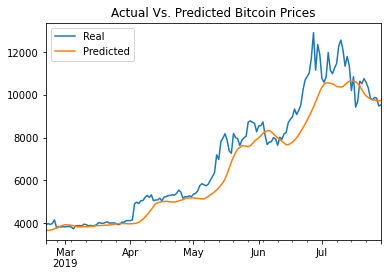

In [72]:
# Plotting the real vs predicted values as a line chart
stocks.plot(title="Actual Vs. Predicted Bitcoin Prices")